# Filtering a log with a striplog


I'd like to 'extract' the data from a log, only where there are intervals. Since we already have ways to filter the striplog to zones of interest (e.g. with find() or filter) it would be easy to, say, get the GR curve where the striplog indicates sandstone.


In [1]:
from welly import Well, Curve
from striplog import Striplog, Legend

% matplotlib inline

## Instantiate a well from an LAS

In [2]:
P129 = Well.from_las('data/las/P-129_out.LAS')
P129

## Make a striplog

In [3]:
legend = Legend.default(name='nsdoe')

In [4]:
strip_im = 'data/images/P-129_280_1935.png'
strip = Striplog.from_image(strip_im, 280, 1935, legend=legend)

Add the striplog to the well object

In [5]:
P129.data['strip']=strip

Find all the occurences of the word 'mudstone' in the striplog.

In [6]:
muds = P129.data['strip'].find('mudstone')
muds

Striplog(38 Intervals, start=414.9914289369323, stop=1904.5549443520533)

We can see it has found 38 intervals. Doing a plot of `muds` without passing a legend, we can see that we get mudstones in 2 different decors.

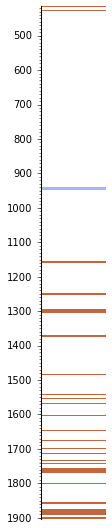

In [7]:
muds.plot(aspect=5)

This is because there are two types of mud in the striplog:

In [8]:
muds.unique

[(Component({'colour': 'grey', 'grainsize': '', 'lithology': 'mudstone'}),
  114.4124344377633),
 (Component({'colour': 'red', 'grainsize': '', 'lithology': 'mudstone'}),
  8.468722016118818)]

Let's assign this filtered striplog to the key 'muds' in the well object so we can hold everything in one place.

In [9]:
P129.data['muds'] = muds

Create a log-like flag of where these mudstones exist. Use depth basis from the gamma-ray log.

In [10]:
gr = P129.data['GR']

In [11]:
mud_flag = muds.to_flag(basis=gr.basis)
mud_flag

array([False, False, False, ..., False, False, False], dtype=bool)

In [12]:
pdict = {'start':gr.start, 'step':gr.step, 'mnemonic':'MUDFLG', 'units':'flag'}

In [13]:
P129.data['MUDFLG'] = Curve(mud_flag, params=pdict)

In [14]:
P129.data['MUDFLG']

Curve([False, False, False, ..., False, False, False], dtype=bool)

We can add the new style definitions for our mudline to the orignal legend

In [15]:
# add a display styles to the mudflag curve and gamma ray (GR)
mud_track = """colour,lw,xscale,curve mnemonic
#FF0000,0.5,linear,MUDFLG,
#BBCCBB,0.5,linear,GR,
"""
mud_legend = Legend.from_csv(mud_track)

In [16]:
complete_legend = legend + mud_legend

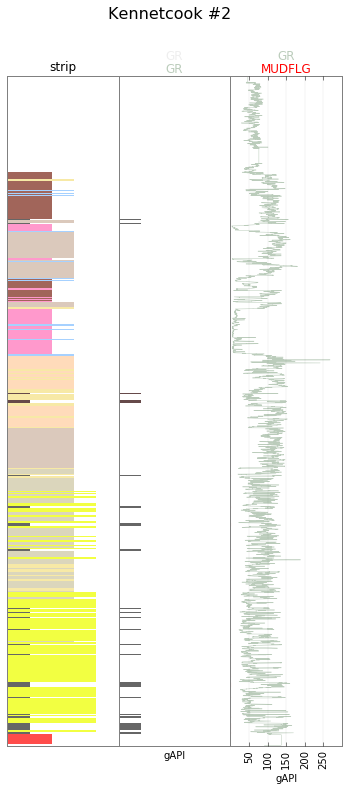

In [17]:
tracks = ['strip', ['GR', 'muds'], ['MUDFLG','GR']]
P129.plot(tracks=tracks, legend=complete_legend)

The first two tracks are striplogs, the third track contains logs; the GR log and the MUDFLG log we created from filtering the original striplog. Note: some flags may not appear if the resolution of the graphic is not high enough

In [18]:
muddy_GR = gr * mud_flag

A quick plot of the filtered GR log shows what all GR values are greater than 100 (muddy!)

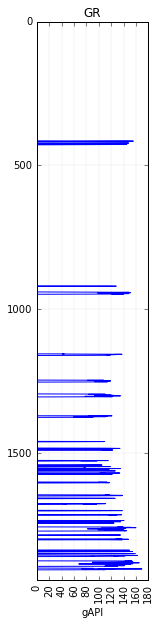

In [19]:
muddy_GR.plot()

Or we can find the mean GR of the muds:

In [20]:
gr[mud_flag].mean()

Curve(114.86171976266668)

# Highlight the mudstones on the GR log

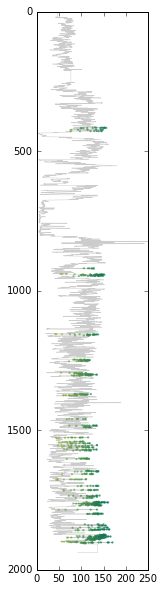

In [21]:
import matplotlib.pyplot as plt
f = plt.figure(figsize=(2,10))
ax1 = f.add_subplot(111)
ax1.plot(gr.data, gr.basis, c='k',alpha=0.2, lw=0.5)
ax1.scatter(muddy_GR.data, muddy_GR.basis, c=muddy_GR.data, s=5, edgecolor='', cmap='summer_r', clim=(10,200), alpha=0.75)
ax1.set_ylim(0,2000)
ax1.set_xlim(0,250)
ax1.invert_yaxis()